# Modeling Pipeline for the 2014 COCO dataset<br>
This notebook loads data from the 2014 COCO training dataset, trains a deep learning model, and evaluates the results. We split the training dataset into training, validation, and testing data since we do not yet require all of the images at this stage in our project development.<br>
This notebook uses the LeNet-5 model and utilizes the method outlined in [this article](https://towardsdatascience.com/master-the-coco-dataset-for-semantic-image-segmentation-part-1-of-2-732712631047).
 
Authors: Péter Hámori, Audrea Huang<br>
Date: 11 May 2021<br>
AIT Deep Learning Final Project<br>



### Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# visualize outputs
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import skimage.io as io

# data processing
from pycocotools.coco import COCO
import cv2
from skimage.transform import resize
import numpy as np
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [ ]:
import random

# keras
from keras.utils import to_categorical 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [ ]:
annFileTrain = '/content/drive/MyDrive/Colab Notebooks/AIT_DeepLearning/coco project/instances_train2014.json'

Create helper functions

In [ ]:
def getClassName(classID, cats):
  '''
  Iterate through the categories to extract the desired class name.
  :param  classID (int)         : requested class ID
  :param  cats (list of strings): requested categories
  :return: string: class name or "None" if none found
  '''
  for i in range(len(cats)):
      if cats[i]['id']==classID:
          return cats[i]['name']
  return "None"

In [ ]:
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    '''
    Mask outlining each specific class of interest.

    :param imageObj (dict): input image
    :param classes (list of strings): classes of interest
    :param coco (COCO): instance annotations
    :param catIds (list of integers): category IDs
    :param input_image_size (tuple): size of input image
    :return: train_mask(ndarray): mask
    '''
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  

In [ ]:
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    '''
    Mask indicating which parts of the image correspond to classes of interest.

    :param imageObj (dict): input image
    :param coco (COCO): instance annotations
    :param catIds (list of integers): category IDs
    :param input_image_size (tuple): size of input image
    :return: train_mask(ndarray): binary mask
    '''

    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

In [ ]:
def visualizeImageAndMask(img, mask):
    '''
    Display image and its corresponding mask.
    :param  img(ndarray): specified image
    :param  mask(ndarray): corresponding mask  
    '''
 
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)

    ax = plt.Subplot(fig, outerGrid[0])
    ax.imshow(img);

    ax = plt.Subplot(fig, outerGrid[1])
    ax.imshow(mask[:,:,0]);

    ax.axis('off')
    fig.add_subplot(ax)

    plt.show()
    return

In [ ]:
def visualizeImage(img):
  '''
  Display image.
  :param  img(ndarray): specified image
  '''
 
  fig = plt.figure(figsize=(20, 10))
  outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)

  ax = plt.Subplot(fig, outerGrid[0])
  ax.imshow(img);

  ax.axis('off')
  fig.add_subplot(ax)

  plt.show()
  return

In [ ]:
def getImage(imageObj, input_image_size):
    '''
    Return a specified image, rescaled to the desired size
    :param   imageObj (int)          : requested image object
    :param   input_image_size (tuple): size of image
    :return: image: image of specified size
    '''
    # Read and normalize an image
    train_img = io.imread(imageObj['coco_url'])/255.0

    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img

In [ ]:
def concatenate_image_mask(img, mask):
  '''
  Combine image and mask to feed to model.

  :param img (ndarray): image
  :param mask (ndarray): corresponding mask
  :return concat (ndarray): concatenated image and model
  '''
  img = img.reshape(224*224*3)
  mask = mask.reshape(224*224*1)
  concat = np.concatenate((img, mask))
  concat = concat.reshape(224,224,4)
  return concat

### MULTICLASS CLASSIFICATION
Produce multiple outputs to encompass all objects we detect in the image.

In [ ]:
def getData(number_of_samples, images, classes, coco, input_image_size=(224,224), 
            batch_size=4, mode='train', mask_type='binary'):
  '''
  Get images and corresponding masks.

  :param number_of_samples (int): sample size
  :param images (list of dictionaries): images in dataset
  :param classes (list of strings): object classes of interest
  :param coco (COCO): instance annotations
  :param input_image_size (tuple): width and height of input
  :param batch_size (int): batch size
  :param mode (string): train, valid, or test
  :param mask_type (string): binary or normal
  :return im: list of images
  :return m: list of masks
  '''
  dataset_size = len(images)
  catIds = coco.getCatIds(catNms=classes)

  im = []
  m = []

  for i in range(number_of_samples):
    if i % 100 == 0:
      print(i)
      
    imageObj = images[i]

    # Retrieve Image
    train_img = getImage(imageObj, input_image_size)
            
    # Create Mask
    if mask_type == "binary":
      train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
    elif mask_type == "normal":
      train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)     

    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)

    im.append(train_img)
    m.append(train_mask)
  
  return im, m


In [ ]:
def get_targets(number_of_samples, images, classes, coco, input_image_size=(224,224)):
  '''
  Get labels for the images.
  :param number_of_samples (int):          number of images we are considering
  :param images (list of images):          input images
  :param classes (list of strings):        classes we are considering
  :param coco (COCO):                      COCO configuration
  :param input_image_size (tuple of ints): width, height of each input image
  :return y (list of strings): labels corresponding to each image 
                               (listed out in the same order as 'images')
  '''
  y = []
  
  catIds = coco.getCatIds(catNms=classes)
  cats = coco.loadCats(catIds)

  for i in range(number_of_samples):
    o = []
    imageObj = images[i]
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)  
        o.append(className)

    y.append(o[0])
    #for multi labels: 
    #y.append(o)
  return y

In [ ]:
def filterDataset(annFile, classes=None):  
    '''
    Extract images corresponding to the specified classes and remove duplicates.

    :param  annFile (string): relative path for annotations
    :param  classes (list of strings): objects we are interested in detecting
    :return: unique_images (list of images): list with only one instance of each 
      image, which may contain multiple objects of interest
    :return: dataset_size (int): size of dataset corresponding to annFile
    :return: coco (COCO): COCO object for instance annotations
    '''  
    # initialize COCO api for instance annotations
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

Create training dataset and load annotations into memory.

In [ ]:
classes = ['car', 'chair', 'book', 'bottle']
train_images, train_dataset_size, train_coco = filterDataset(annFileTrain, classes)
input_image_size = (224,224)
mask_type = 'normal'

loading annotations into memory...
Done (t=17.98s)
creating index...
index created!


In [ ]:
number_of_samples = 1200

In [ ]:
t_images = []
t_masks = []
t_images, t_masks = getData(number_of_samples, train_images, classes,
                            train_coco, input_image_size, mask_type)

0
100
200
300
400
500
600
700
800
900
1000
1100


In [ ]:
labels = get_targets(number_of_samples, train_images, classes, train_coco, input_image_size)

One-hot encoding of labels we are considering

In [ ]:
representation_dict = {'car': 0, 'chair': 0, 'book': 0, 'bottle': 0}
for i in labels:
  if 'car' in i:
    representation_dict['car'] += 1
  if 'chair' in i:
    representation_dict['chair'] += 1
  if 'book' in i:
    representation_dict['book'] += 1
  if 'bottle' in i:
    representation_dict['bottle'] += 1
representation_dict

{'book': 123, 'bottle': 276, 'car': 414, 'chair': 387}

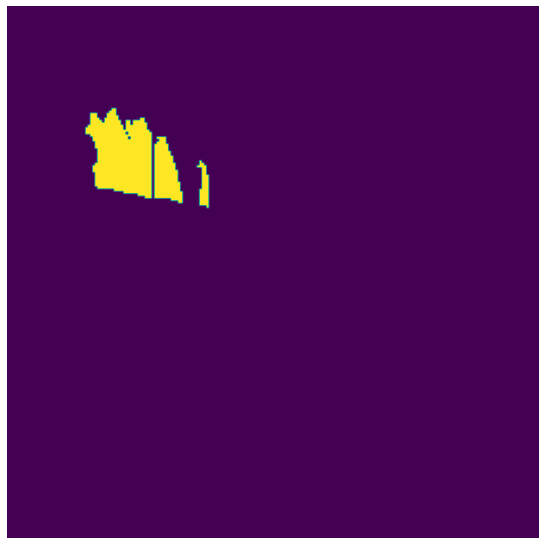

In [ ]:
visualizeImageAndMask(t_images[2], t_masks[2])

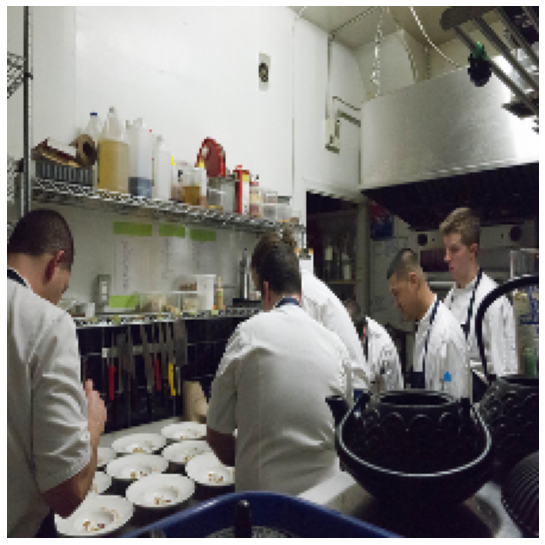

In [ ]:
visualizeImage(t_images[2])

In [ ]:
labels[2]

'bottle'

In [ ]:
#CONCATENATING IMAGES AND MASKS
X = []
for i in range(len(t_images)):
  X.append(concatenate_image_mask(t_images[i], t_masks[i]))

In [ ]:
#PREPROCESSING INPUT
for i in range(len(X)):
    X[i] = X[i]/255.0   #normalizing
    X[i] = np.asarray(X[i]) 
    X[i] = resize(X[i], input_image_size) #reshaping 

In [ ]:
Y = get_targets(number_of_samples, train_images, classes, train_coco, input_image_size)

In [ ]:
#target classes to integers 
for i in range(len(Y)):
    if Y[i] == 'car':
      Y[i] = 0
    elif Y[i] == 'chair':
      Y[i] = 1
    elif Y[i] == 'book':
      Y[i] = 2
    elif Y[i] == 'bottle':
      Y[i] = 3

In [ ]:
Y = to_categorical(Y, 4)  #one-hot encoding

Split training data into train, validation, and test sets

In [ ]:
# TRAIN-VALIDATION-TEST SETS
t_point = int(0.7*len(X))
v_point = int(0.8*len(X))

X_train = []
X_val = []
X_test = []
X_train = X[:t_point]
X_val = X[t_point:v_point]
X_test = X[v_point:]

Y_train = []
Y_val = []
Y_test = []
Y_train = Y[:t_point]
Y_val = Y[t_point:v_point]
Y_test = Y[v_point:]


In [ ]:
Y_train[0] # array of 0s and 1 corresponding to Y = to_categorical - will need to map to produce actual label

array([0., 1., 0., 0.], dtype=float32)

### Create model

In [ ]:
from keras.layers import Conv2D , AveragePooling2D , Dense, Flatten, Dropout
from keras.models import Sequential

In [ ]:
def create_model():
  model = Sequential(name="LeNet-5")
  model.add(Conv2D(16,(5,5),strides=(1,1), activation='tanh',input_shape=(input_image_size[0], input_image_size[1], 3+1))) 
  model.add(AveragePooling2D())
  model.add(Dropout(0.25))
  model.add(Conv2D(32,(5,5),strides=(1,1), activation='tanh'))
  model.add(AveragePooling2D())
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(8,activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer='l2')) 
  model.add(Dropout(0.5))
  model.add(Dense(4,activation='softmax'))

  #Saving the model for visualization perposes 
  model.save("model.h5")
  #Saving the weight of the model for later use
  model.save_weights('model_weights.hdf5')

  #Compile
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "LeNet-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 16)      1616      
_________________________________________________________________
average_pooling2d (AveragePo (None, 110, 110, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 32)      12832     
_________________________________________________________________
average_pooling2d_1 (Average (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 53, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 89888)             0   

In [ ]:
es = EarlyStopping(patience=30, monitor='val_accuracy', restore_best_weights=True)

## Train and evaluate model

Multilabel Classification

In [ ]:
model.fit(np.asarray(X_train), Y_train, epochs=200, batch_size=32, validation_data=(np.asarray(X_val), Y_val), callbacks=([es]))

Epoch 1/200
27/27 [==============================] - 36s 90ms/step - loss: 1.4559 - accuracy: 0.2927 - val_loss: 1.3629 - val_accuracy: 0.3250
Epoch 2/200
27/27 [==============================] - 1s 44ms/step - loss: 1.4193 - accuracy: 0.2790 - val_loss: 1.3295 - val_accuracy: 0.3250
Epoch 3/200
27/27 [==============================] - 1s 43ms/step - loss: 1.3608 - accuracy: 0.3279 - val_loss: 1.3309 - val_accuracy: 0.3250
Epoch 4/200
27/27 [==============================] - 1s 43ms/step - loss: 1.3783 - accuracy: 0.3299 - val_loss: 1.3611 - val_accuracy: 0.4000
Epoch 5/200
27/27 [==============================] - 1s 43ms/step - loss: 1.3619 - accuracy: 0.3506 - val_loss: 1.3708 - val_accuracy: 0.3250
Epoch 6/200
27/27 [==============================] - 1s 43ms/step - loss: 1.3680 - accuracy: 0.3596 - val_loss: 1.3220 - val_accuracy: 0.3667
Epoch 7/200
27/27 [==============================] - 1s 43ms/step - loss: 1.3381 - accuracy: 0.3750 - val_loss: 1.3201 - val_accuracy: 0.3833
Epoch

### Evaluate

In [ ]:
from sklearn.metrics import hamming_loss, accuracy_score, precision_score, f1_score, recall_score

In [ ]:
loss, acc = model.evaluate(np.asarray(X_test), Y_test)

8/8 [==============================] - 0s 33ms/step - loss: 1.3774 - accuracy: 0.3750


In [ ]:
preds = model.predict(np.asarray(X_test))

In [ ]:
preds[:10]

array([[0.29775408, 0.306234  , 0.11424293, 0.281769  ],
       [0.32942522, 0.2837318 , 0.10159871, 0.28524426],
       [0.30022955, 0.2996877 , 0.11015051, 0.2899323 ],
       [0.30288246, 0.31536955, 0.10080791, 0.28094012],
       [0.22116405, 0.33699343, 0.12605567, 0.31578684],
       [0.299236  , 0.28358063, 0.12923637, 0.287947  ],
       [0.19502856, 0.31589252, 0.12982202, 0.35925692],
       [0.27418122, 0.30965778, 0.11519749, 0.30096352],
       [0.2703101 , 0.31172797, 0.11269479, 0.30526713],
       [0.22321264, 0.34171465, 0.11999693, 0.31507578]], dtype=float32)

In [ ]:
probas = np.zeros((len(preds), 4))
for i, p in enumerate(preds): 
  if p[0] == max(p):
    probas[i][0] = 1
  if p[1] == max(p):
    probas[i][1] = 1
  if p[2] == max(p):
    probas[i][2] = 1
  if p[3] == max(p):
    probas[i][3] = 1
probas[:10]

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
Y_test[:10]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
print('Detailed evaluation:')
print('\tAccuracy: ', round(accuracy_score(Y_test, probas),2))
print('\tPrecision: ', round(precision_score(Y_test, probas, average='macro'),2))
print('\tRecall: ', round(recall_score(Y_test, probas, average='macro'), 2))
#print('\tHamming: ', round(hamming_loss(Y_test, probas), 2))
print('\tF1: ', round(f1_score(Y_test, probas, average='macro'), 2))

Detailed evaluation:
	Accuracy:  0.38
	Precision:  0.3
	Recall:  0.32
	F1:  0.29


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dict = {'car': 0, 'chair': 0, 'book': 0, 'bottle': 0}
for i, proba in enumerate(probas): 
  if proba[0] == Y_test[i][0]:
    dict['car'] += 1
  if proba[1] == Y_test[i][1]:
    dict['chair'] += 1
  if proba[2] == Y_test[i][2]:
    dict['book'] += 1
  if proba[3] == Y_test[i][3]:
    dict['bottle'] += 1
print('Class-wise accuracies:')
for c in list(dict.keys()):
  print('\t', c, ': ', round(dict[c]/len(probas), 2))  

Class-wise accuracies:
	 car :  0.68
	 chair :  0.56
	 book :  0.87
	 bottle :  0.65


## MULTILABEL CLASSIFICATION
Given multiple possible options of classes, produce the label of the dominant object in image (the object with the highest confidence level).

In [ ]:
def filterDataset_multi(coco, classes=None):  
    '''
    Extract images corresponding to the specified classes and remove duplicates.

    :param  annFile (string): relative path for annotations
    :param  classes (list of strings): objects we are interested in detecting
    :return: unique_images (list of images): list with only one instance of each 
      image, which may contain multiple objects of interest
    :return: dataset_size (int): size of dataset corresponding to annFile
    :return: coco (COCO): COCO object for instance annotations
    '''  
    # initialize COCO api for instance annotations
    #coco = COCO(annFile)
    
    images = []
    for i in range(len(classes)):
        catIds = coco.getCatIds(catNms=classes[i])
        imgIds = coco.getImgIds(catIds=catIds)
        images += coco.loadImgs(imgIds)
    
    for i in range(len(classes)-1):
        # iterate for each individual class in the list
        #for className in classes:
        # get all images containing given categories
        catIds = coco.getCatIds(catNms=classes[i:i+2])
        imgIds = coco.getImgIds(catIds=catIds)
        images += coco.loadImgs(imgIds)

    for i in range(len(classes)-2):
        catIds = coco.getCatIds(catNms=classes[i:i+3])
        imgIds = coco.getImgIds(catIds=catIds)
        images += coco.loadImgs(imgIds)
    
    for i in range(len(classes)-3):
        catIds = coco.getCatIds(catNms=classes[i:i+4])
        imgIds = coco.getImgIds(catIds=catIds)
        images += coco.loadImgs(imgIds)
    
      
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [ ]:
def get_targets_multi(number_of_samples, images, classes, coco, input_image_size=(224,224)):
  y = []
  
  catIds = coco.getCatIds(catNms=classes)
  cats = coco.loadCats(catIds)

  for i in range(number_of_samples):
    o = []
    imageObj = images[i]
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)  
        o.append(className)

    #for multi labels: 
    y.append(o)
  return y

In [ ]:
coco = COCO(annFileTrain)

loading annotations into memory...
Done (t=13.76s)
creating index...
index created!


In [ ]:
classes = ['car', 'chair', 'book', 'bottle']
train_images_multi, train_dataset_size, train_coco = filterDataset_multi(coco, classes)
input_image_size = (224,224)
mask_type = 'normal'

In [ ]:
len(train_images_multi)

23177

In [ ]:
t_images_multi = []
t_masks_multi = []
number_of_samples_multi = 1000
t_images_multi, t_masks_multi = getData(number_of_samples_multi, train_images_multi, classes,
                            train_coco, input_image_size, mask_type)

0
100
200
300
400
500
600
700
800
900


In [ ]:
labels_multi = get_targets_multi(number_of_samples_multi, train_images_multi, classes, train_coco, input_image_size)

In [ ]:
representation_dict_multi = {'car': 0, 'chair': 0, 'book': 0, 'bottle': 0}
for i in labels_multi:
  if 'car' in i:
    representation_dict_multi['car'] += 1
  if 'chair' in i:
    representation_dict_multi['chair'] += 1
  if 'book' in i:
    representation_dict_multi['book'] += 1
  if 'bottle' in i:
    representation_dict_multi['bottle'] += 1
representation_dict_multi

{'book': 169, 'bottle': 263, 'car': 354, 'chair': 415}

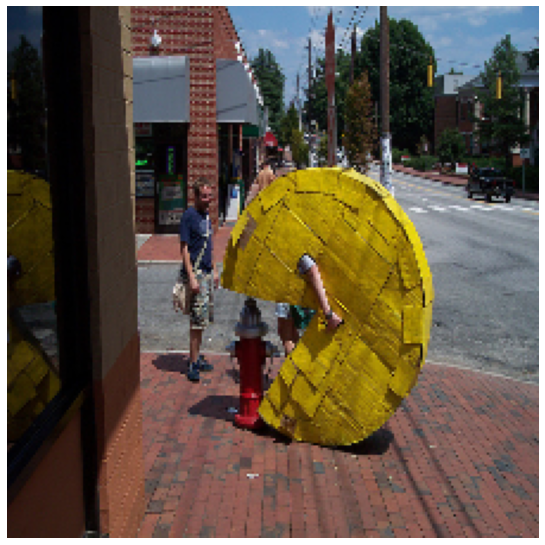

In [ ]:
visualizeImage(t_images_multi[5])

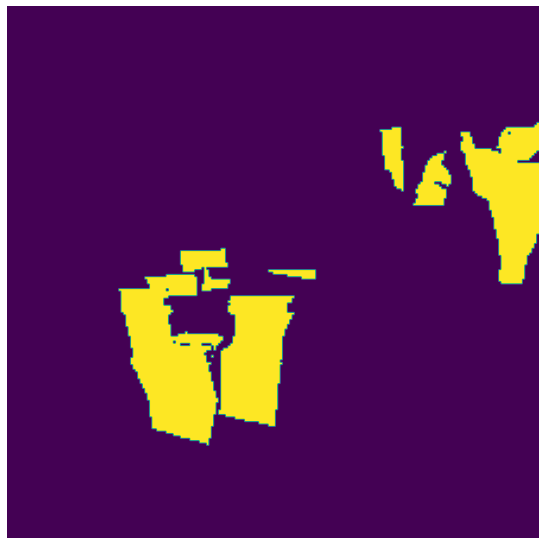

In [ ]:
visualizeImageAndMask(t_images_multi[31], t_masks_multi[31])

In [ ]:
Y_multi =  np.zeros((number_of_samples_multi, len(classes)))
for j, i in enumerate(labels_multi): 
  if 'car' in i: 
    Y_multi[j][0] = 1
  if 'chair' in i: 
    Y_multi[j][1] = 1
  if 'book' in i: 
    Y_multi[j][2] = 1
  if 'bottle' in i: 
    Y_multi[j][3] = 1

In [ ]:
print(labels_multi[:10])
print(Y_multi[:10])

[['car', 'car'], ['car', 'bottle', 'chair', 'chair', 'chair'], ['chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair'], ['car'], ['chair'], ['car'], ['book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book', 'book'], ['bottle', 'bottle', 'bottle', 'bottle', 'bottle'], ['car', 'car', 'car', 'car', 'car', 'car'], ['bottle', 'bottle']]
[[1. 0. 0. 0.]
 [1. 1. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


In [ ]:
X_multi = []
for i in range(len(t_images_multi)):
  X_multi.append(concatenate_image_mask(t_images_multi[i], t_masks_multi[i]))

for i in range(len(X_multi)):
    X_multi[i] = X_multi[i]/255.0   #normalizing
    X_multi[i] = np.asarray(X_multi[i]) 
    X_multi[i] = resize(X_multi[i], input_image_size) #reshaping

Split complete dataset into train, validation, and test sets.

In [ ]:
# TRAIN-VALIDATION-TEST SETS
t_point = int(0.7*len(X))
v_point = int(0.8*len(X))

X_train_multi = []
X_val_multi = []
X_test_multi = []
X_train_multi = X[:t_point]
X_val_multi = X[t_point:v_point]
X_test_multi = X[v_point:]

Y_train_multi = []
Y_val_multi = []
Y_test_multi = []
Y_train_multi = Y[:t_point]
Y_val_multi = Y[t_point:v_point]
Y_test_multi = Y[v_point:]


Create the multilabel classification model.

In [ ]:
def create_model_multi():
  ''' Define the multilabel classification model. '''
  model = Sequential(name="LeNet-5")
  model.add(Conv2D(16,(5,5),strides=(1,1), activation='tanh',input_shape=(input_image_size[0], input_image_size[1], 3+1))) 
  model.add(AveragePooling2D())
  model.add(Dropout(0.25))
  model.add(Conv2D(32,(5,5),strides=(1,1), activation='tanh'))
  model.add(AveragePooling2D())
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(8,activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer='l2')) 
  model.add(Dropout(0.5))
  model.add(Dense(8,activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer='l2')) 
  model.add(Dropout(0.5))
  model.add(Dense(4,activation='sigmoid', kernel_initializer='glorot_uniform', kernel_regularizer='l2'))

  #Saving the model for visualization perposes 
  model.save("model_multi.h5")
  #Saving the weight of the model for later use
  model.save_weights('model_weights_multi.hdf5')

  #Compile
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model_multi = create_model_multi()

In [ ]:
es = EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True)

In [ ]:
# Fit the model on the training data
model_multi.fit(np.asarray(X_train_multi), Y_train_multi, epochs=200, batch_size=32, validation_data=(np.asarray(X_val_multi), Y_val_multi), callbacks=([es]))

In [ ]:
# Evaluate the model's accuracy and loss
loss_multi, acc_multi = model.evaluate(np.asarray(X_test_multi), Y_test_multi)

In [ ]:
# Make predictions for the test set
preds_multi = model.predict(np.asarray(X_test_multi))

In [ ]:
preds_multi[:20]

array([[0.5003442 , 0.49946502, 0.50038284, 0.49954683],
       [0.5005478 , 0.49894527, 0.5007642 , 0.4991602 ],
       [0.50021875, 0.4995009 , 0.50036657, 0.49954587],
       [0.50063014, 0.49936995, 0.5004471 , 0.49940455],
       [0.5003075 , 0.4994745 , 0.5005061 , 0.4993298 ],
       [0.50045663, 0.4992344 , 0.50039154, 0.499414  ],
       [0.5000364 , 0.49978253, 0.50007117, 0.49975026],
       [0.50075716, 0.49894187, 0.50072116, 0.49920934],
       [0.50049204, 0.49944332, 0.50034463, 0.49961692],
       [0.5003104 , 0.4996862 , 0.50037426, 0.4996612 ],
       [0.50075364, 0.49940276, 0.50054777, 0.49922478],
       [0.500161  , 0.50032026, 0.50016767, 0.49961203],
       [0.5006445 , 0.49902925, 0.5004808 , 0.49906024],
       [0.49998903, 0.49982435, 0.5001601 , 0.49982923],
       [0.5003268 , 0.49924344, 0.50048786, 0.49955526],
       [0.5002675 , 0.4995202 , 0.5003929 , 0.49950778],
       [0.50042033, 0.4992661 , 0.5003181 , 0.49964276],
       [0.5005748 , 0.49930325,